### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

# Hilbert-Huang Transform (HHT)

The Hilbert-Huang Transform (HHT) is an advanced signal processing technique that combines Empirical Mode Decomposition (EMD) with the Hilbert Spectral Analysis to analyze non-linear and non-stationary signals. The process allows for the extraction of instantaneous frequency data.

### Working Principle of HHT

1. **Empirical Mode Decomposition (EMD)**:
   - **Decompose Signal**: The first step is using EMD to break down the original complex signal into IMFs. Each IMF contains well-behaved oscillations that make them suitable for further analysis.

2. **Hilbert Transform**:
   - **Apply Hilbert Transform**: Each of the IMFs from the EMD process is then subjected to the Hilbert Transform. This mathematical transformation helps in deriving the analytical signal from each IMF.
   - **Analytical Signal**: The result of applying the Hilbert Transform is a complex-valued analytical signal for each IMF, where the real part is the original IMF, and the imaginary part is the Hilbert Transform of the IMF.
   - **Instantaneous Amplitude and Phase**: From the analytical signal, we can calculate the instantaneous amplitude (envelope) and the instantaneous phase. The derivative of the instantaneous phase gives we the instantaneous frequency.

3. **Hilbert Spectrum**:
   - **Construct the Spectrum**: By plotting the amplitude of each IMF against its instantaneous frequency over time, a Hilbert Spectrum is formed. This spectrum provides a time-frequency representation of the original signal.
   - **Energy and Frequency Over Time**: The spectrum shows how the energy (amplitude) of various frequency components of the signal evolves over time.

### Why Use HHT?

- **Detailed Time-Frequency Analysis**: Unlike Fourier transform, which only provides frequency information averaged over the entire signal length, HHT provides time-dependent frequency information, making it incredibly powerful for analyzing signals whose frequency components change over time.
- **Handling Non-Linear and Non-Stationary Data**: HHT does not require the signal to be linear or stationary. This makes it suitable for real-world signals that often do not adhere to these conditions, such as economic, seismic, or biomedical signals.

By combining EMD and Hilbert Spectral Analysis, HHT is particularly effective in providing a clear and detailed view of how signals behave, change, and interact over time.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as  nn
import torch.optim as optim
import torch

In [2]:
# Selecting the dataset. Change the file path and type of data. Manual
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"

# Reading the data
dataset = pd.read_excel(file_path)

print("The shape of the dataset: ", dataset.shape)
print("The first 5 entries are:" )
print(dataset.head())


The shape of the dataset:  (669, 2)
The first 5 entries are:
   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452


In [3]:
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]

# selecting the hyperparameters for the dataset from excel
hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

# finding the hyperparameters for the dataset
for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

# type of dataset as in weekly or monthly. need to set this manual after looking at the dataset values
type_of_dataset = "Weekly" # "Weekly" or "Monthly

# select the index of time, manual
index_of_cases = 1

# select the forecast type manual
forecast_type = "Medium" # "Short" or "Medium" or "Long"

p = hyperparameters[forecast_type][hyperparameters_index]
k = (p+1)//2

pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

if type_of_dataset == "Weekly":
    pred_length = pred_length_weekly[forecast_type]
else:
    pred_length = pred_length_monthly[forecast_type]

test_size = pred_length
valid_size = 2*pred_length
train_size = dataset.shape[0] - test_size - valid_size-p # p is the lag, so train size wont contain the first p values


print("The value of p:",p)
print("The value of k:", k)
print("The prediction length is:", pred_length)



The value of p: 12
The value of k: 6
The prediction length is: 26


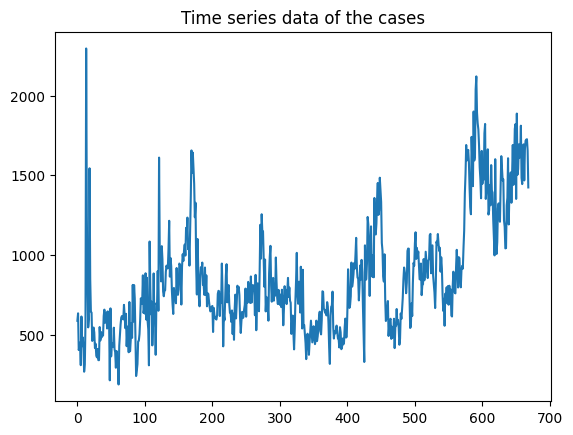

In [4]:
# changing to time series data
cases_time_series = dataset.iloc[:, index_of_cases].values
plt.plot(cases_time_series)
plt.title("Time series data of the cases")
plt.show()

In [5]:
cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)


In [6]:
from PyEMD import EMD
from scipy.signal import hilbert

# Performing HHT on the IMFs obtained via EMD

In [7]:
def manual_hilbert(imf):
    # Step 1: Compute the Fourier Transform
    N = len(imf)
    imf_fft = np.fft.fft(imf)
    
    # Step 2: Create a filter h for the Hilbert transform, Doubles the height of the positive and get rid of the negatives.
    h = np.zeros(N)
    if N % 2 == 0:
        # N is even
        h[0] = 1
        h[1:N//2] = 2
        # Nyquist frequency should remain unchanged, h[N//2] = 1 implicitly as h is initialized with zeros
        # Negative frequencies are already set to zero
    else:
        # N is odd
        h[0] = 1
        h[1:(N//2) + 1] = 2
        # Negative frequencies are already set to zero
        
    # Apply the filter to the FFT of the signal
    imf_fft_filtered = imf_fft * h
    
    # Step 3: Compute the Inverse Fourier Transform
    hilbert_transform = np.fft.ifft(imf_fft_filtered)
    return hilbert_transform


**Filter Creation**: A filter `h` is then created. This filter is designed to prepare the signal for the Hilbert Transform:
   - For an even number of points (`N` is even), it sets the first half of the filter to double the frequency components (to account for positive frequencies) except for the Nyquist frequency (the midpoint of the FFT), which is left as is (implicitly, since the filter is initially all zeros).
   - For an odd number of points (`N` is odd), it does a similar thing but includes the middle point, which is the highest positive frequency component in this case.

**Filter Application**: The filter `h` is then applied to the frequency domain representation of the signal (`imf_fft`). This is done by multiplying the filter `h` with `imf_fft`. This step zeroes out the negative frequency components and doubles the positive ones except for the DC component (mean of the signal) and the Nyquist component when `N` is even.

**Inverse Fourier Transform**: Finally, the code transforms the filtered signal back into the time domain using the Inverse FFT. The result is a complex signal where the real part is the original signal and the imaginary part is the Hilbert Transform of the signal.

In [8]:
# Perform EMD
emd = EMD()
imfs = emd.emd(cases_time_series_scaled)
IMFs2 = [manual_hilbert(imf) for imf in imfs]
# IMFs = [hilbert(imf) for imf in imfs]
IMFs = np.array(IMFs2)
n_imfs = len(IMFs)

/home/ameychoudhary4/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ameychoudhary4/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


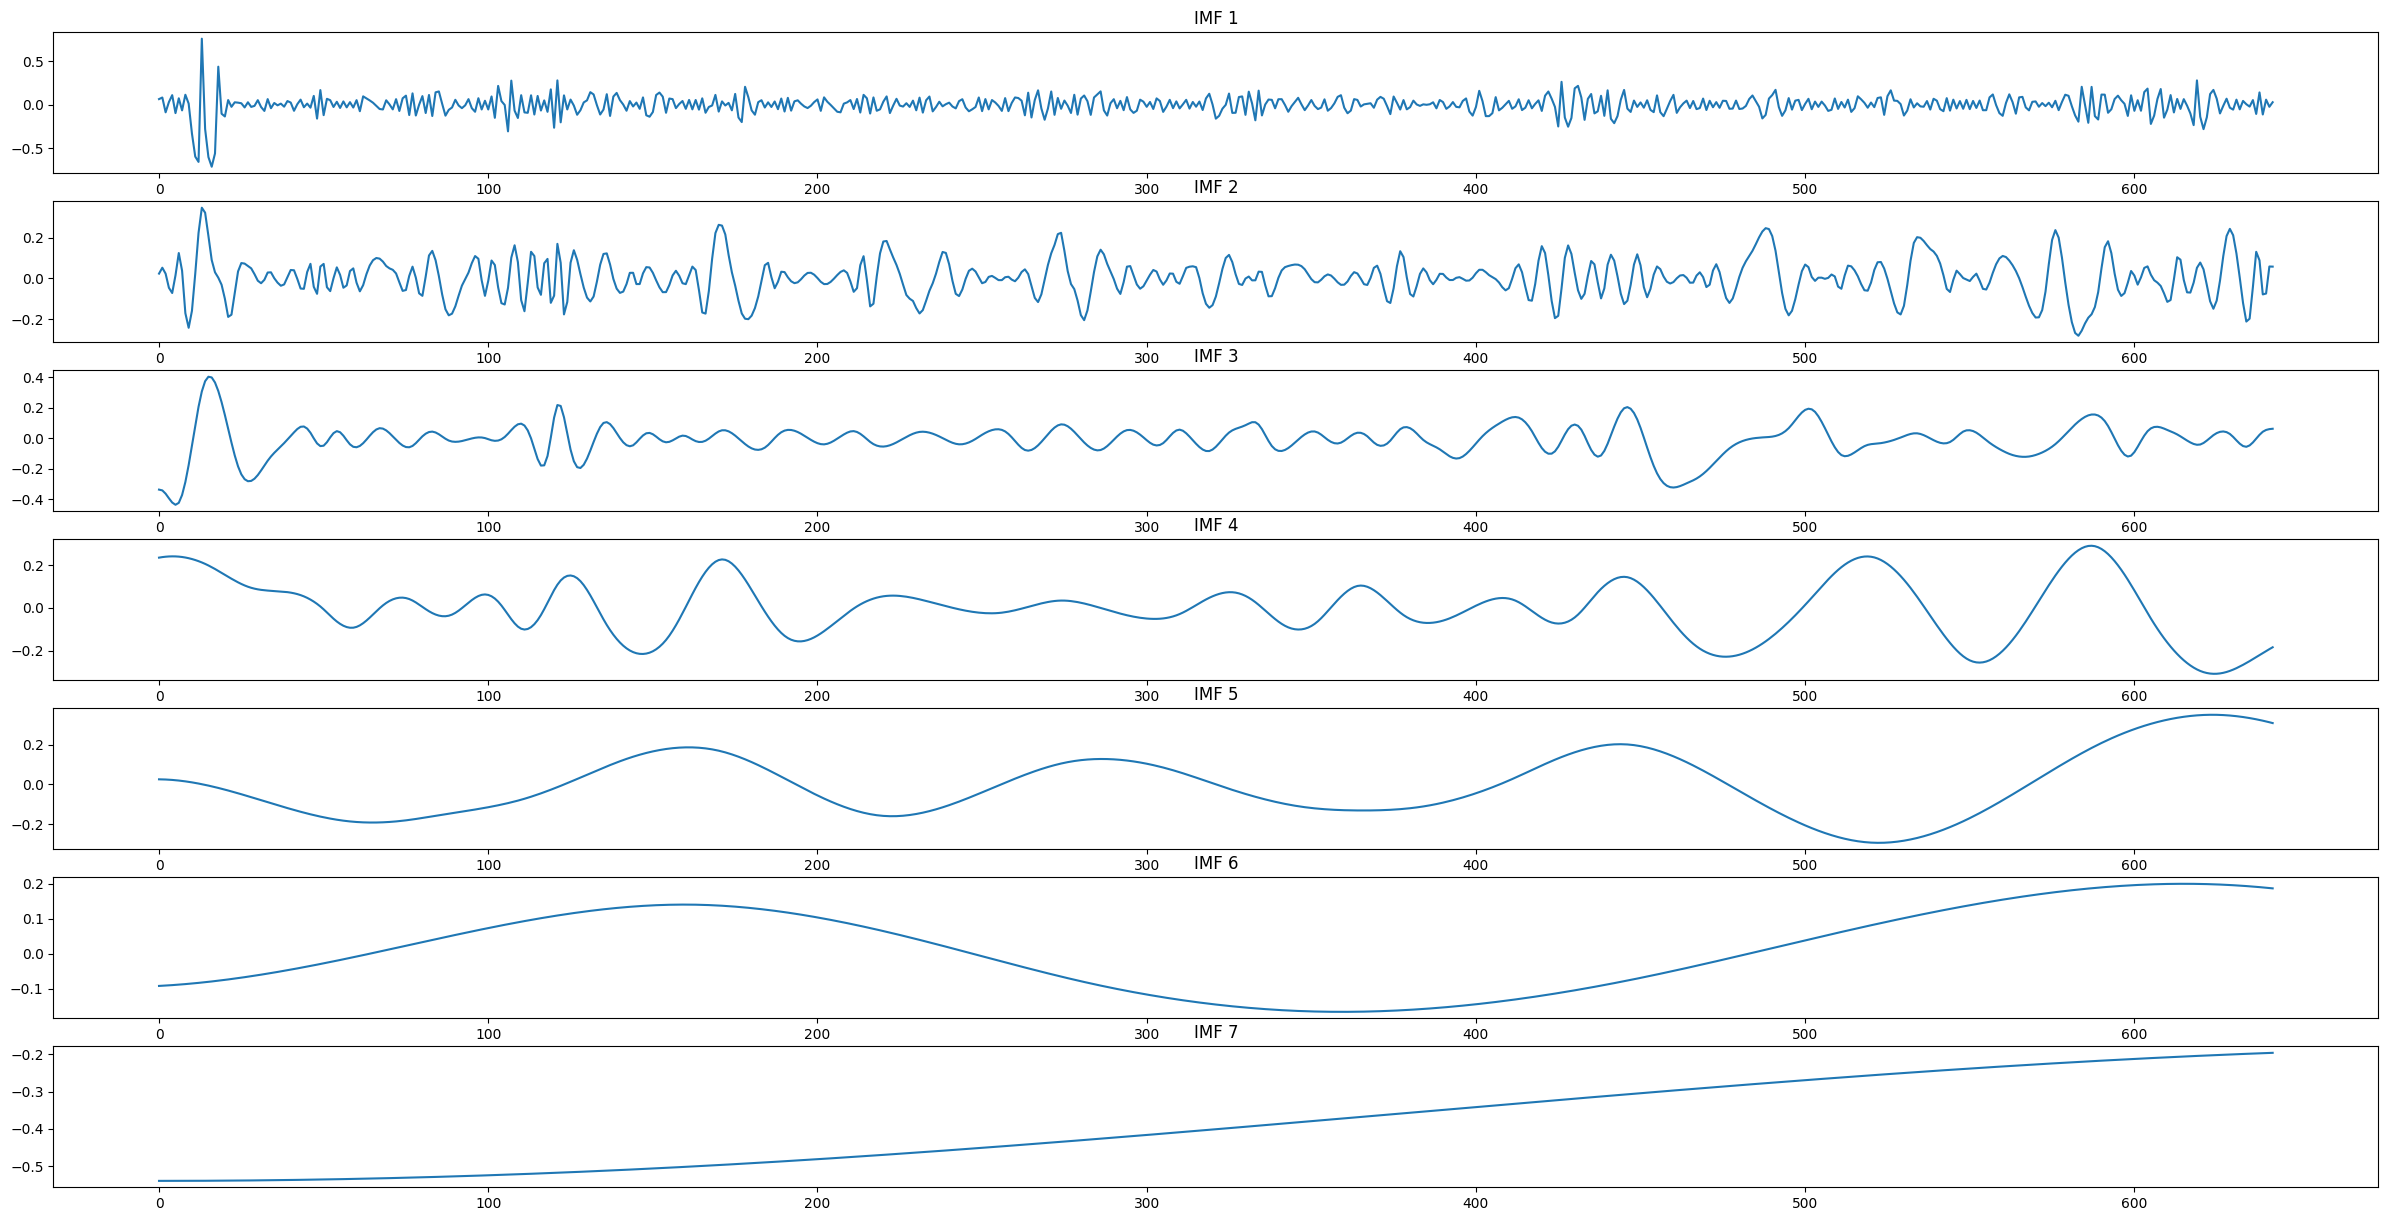

In [9]:
# plotting the IMFs
plt.figure(figsize=(30, 15))
for i in range(n_imfs):
    plt.subplot(n_imfs, 1, i+1)
    plt.plot(IMFs[i, :])
    plt.title("IMF "+str(i+1))
plt.show()


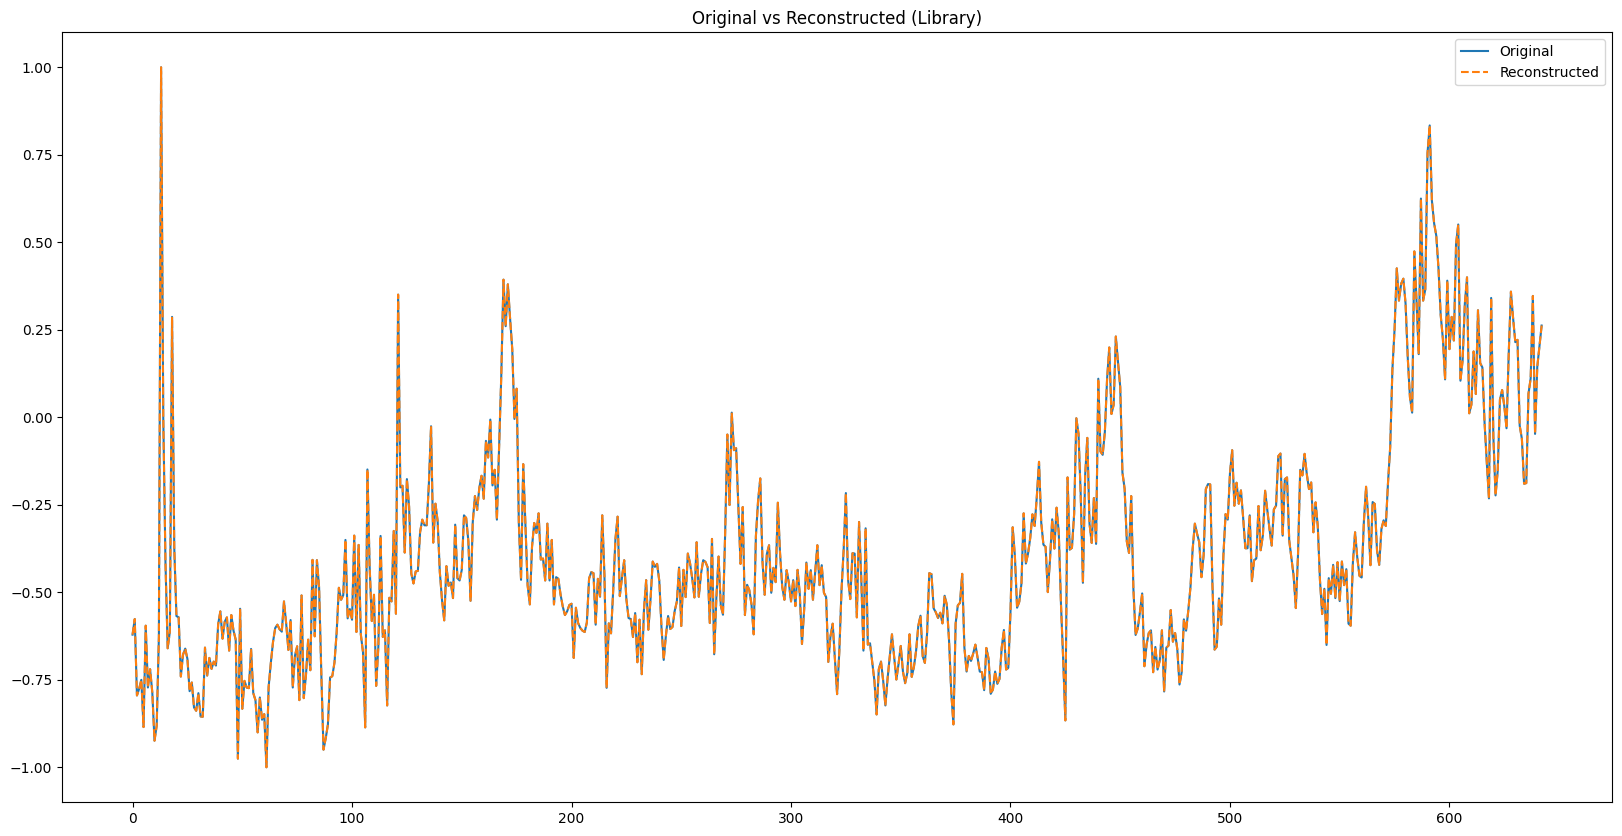

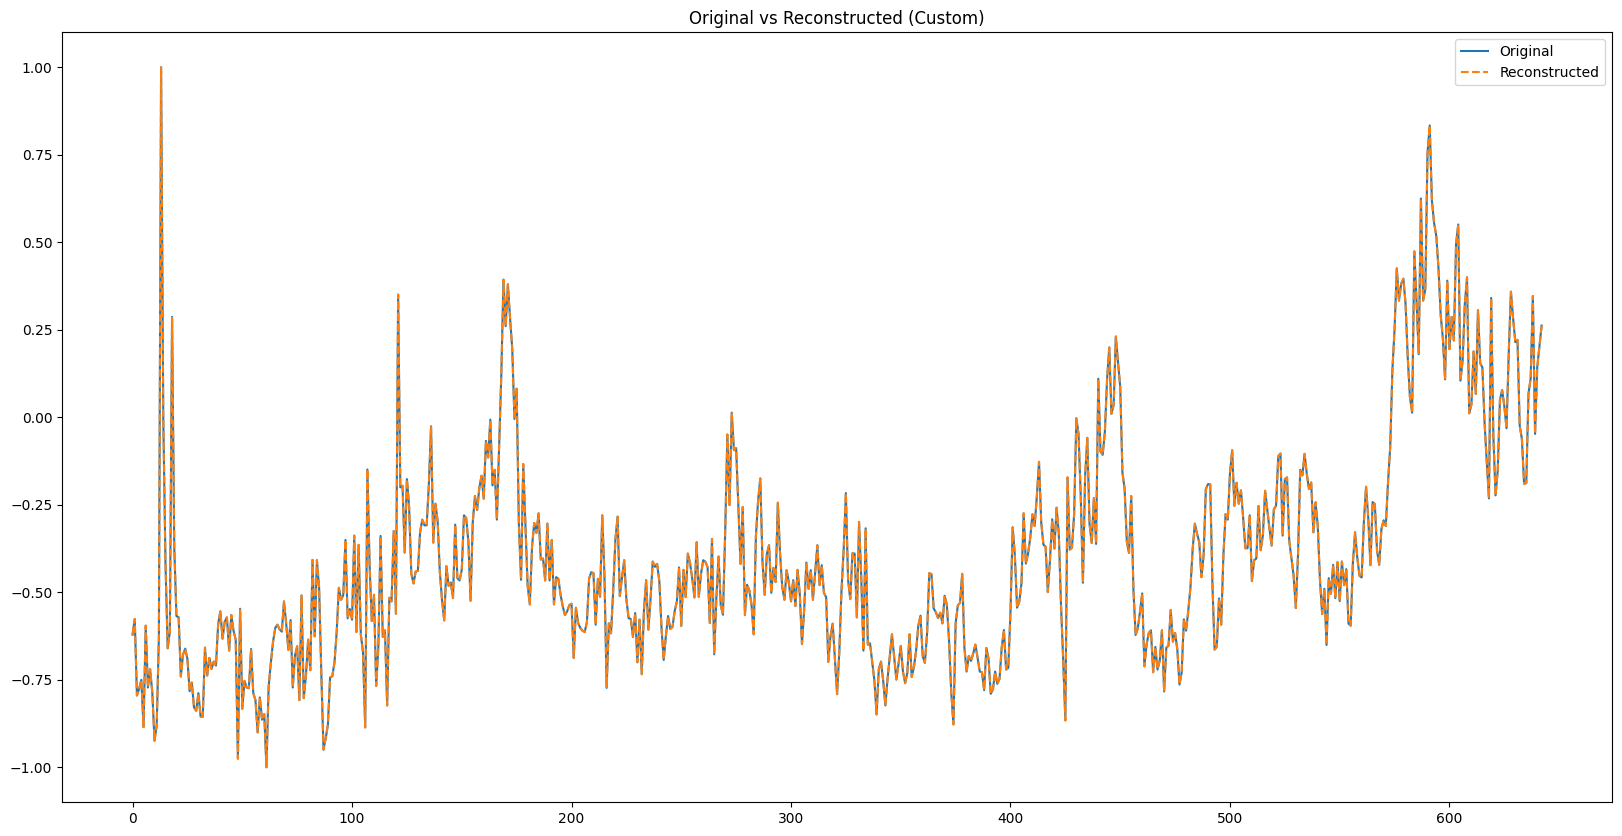

In [10]:
# checking the IMFs and actual
reconstructed_time_series = IMFs.sum(axis=0)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed (Library)")
plt.legend()
plt.show()

# Plot imfs2 and actual
IMFs2 = np.array(IMFs2)
reconstructed_time_series2 = IMFs2.sum(axis=0)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series2, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed (Custom)")
plt.legend()
plt.show()

clearly the decomposition is done well

In [11]:
# creating the class for neural network
class EWNet(nn.Module):
    def __init__(self, p, k):
        super(EWNet, self).__init__()
        self.fc1 = nn.Linear(p, k)
        self.fc2 = nn.Linear(k, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [12]:
# creating the train dataset and test dataset

# Define function to create lagged sequences
def create_lagged_sequence(data, lag):
    X, y = [], []
    for i in range(len(data)-lag):
        X.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(X), np.array(y)



X_train = []
y_train = []
X_valid = []
y_valid = []

for i in range(n_imfs):
    X, y = create_lagged_sequence(IMFs[i], p)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X_train.append(X[0:train_size])
    y_train.append(y[0:train_size])
    X_valid.append(X[train_size:train_size+valid_size])
    y_valid.append(y[train_size:train_size+valid_size])



/tmp/ipykernel_2601/3687904137.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:301.)
  X = torch.tensor(X, dtype=torch.float32)


In [13]:
print("The shape of X_train[0]:", X_train[0].shape)
print("The shape of y_train[0]:", y_train[0].shape)
print("The shape of X_valid[0]:", X_valid[0].shape)
print("The shape of y_valid[0]:", y_valid[0].shape)

The shape of X_train[0]: torch.Size([579, 12])
The shape of y_train[0]: torch.Size([579])
The shape of X_valid[0]: torch.Size([52, 12])
The shape of y_valid[0]: torch.Size([52])


Training started for model:  1
Epoch:  0 Training Loss:  0.061599843204021454 Validation Loss:  0.062002845108509064
Epoch:  1000 Training Loss:  0.010007811710238457 Validation Loss:  0.011895490810275078
Epoch:  2000 Training Loss:  0.009693383239209652 Validation Loss:  0.01183645986020565
Epoch:  3000 Training Loss:  0.009219324216246605 Validation Loss:  0.011510416865348816
Epoch:  4000 Training Loss:  0.008750712499022484 Validation Loss:  0.01161747332662344
Epoch:  5000 Training Loss:  0.008329764939844608 Validation Loss:  0.012087621726095676
Epoch:  6000 Training Loss:  0.007150746416300535 Validation Loss:  0.012574790976941586
Epoch:  7000 Training Loss:  0.005894368980079889 Validation Loss:  0.013368263840675354
Epoch:  8000 Training Loss:  0.005277376156300306 Validation Loss:  0.014092640951275826
Epoch:  9000 Training Loss:  0.004916691221296787 Validation Loss:  0.013783177360892296
Training completed for model:  1
Training started for model:  2
Epoch:  0 Training L

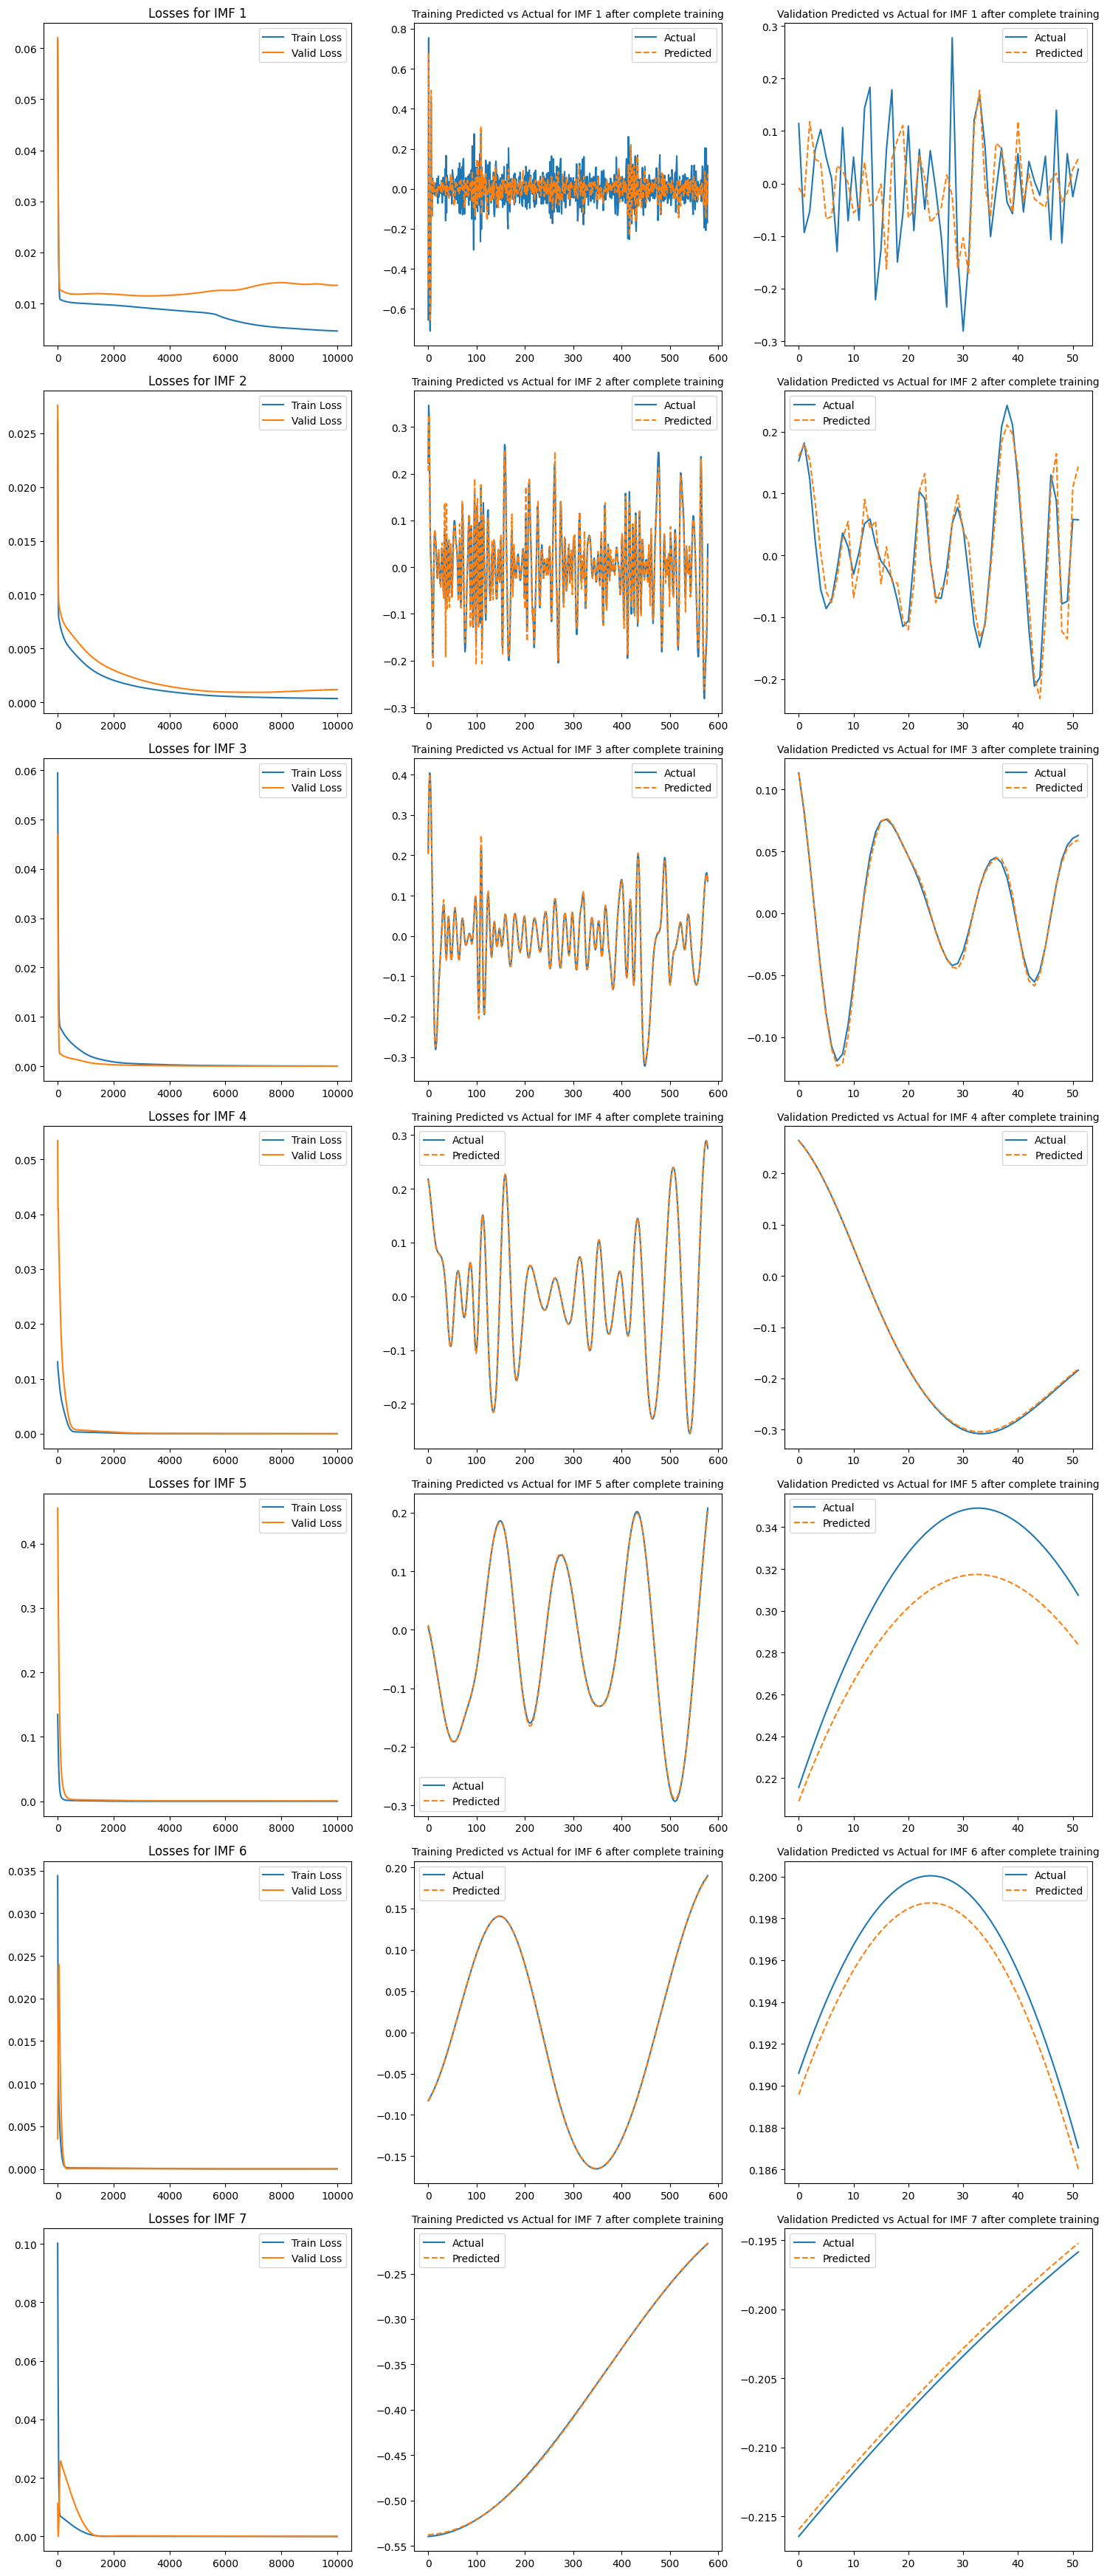

In [14]:
# running the model
n_models = []

fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 5*n_imfs))

for i in range(n_imfs):

    # initializing the model
    model = EWNet(p, k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10000
    print_freq = 10
    epoch_freq = epochs//print_freq
    train_losses = []
    valid_losses = []

    print("Training started for model: ", i+1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_train_pred = model(X_train[i])
        y_train_pred = y_train_pred.view(-1)
        loss = criterion(y_train_pred, y_train[i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            y_valid_pred = model(X_valid[i])
            y_valid_pred = y_valid_pred.view(-1)
            valid_loss = criterion(y_valid_pred, y_valid[i])
            valid_losses.append(valid_loss.item())
        if epoch % epoch_freq == 0:
            print("Epoch: ", epoch, "Training Loss: ", loss.item(), "Validation Loss: ", valid_loss.item())
    print("Training completed for model: ", i+1)

    # Saving the model
    n_models.append(model)

    # Plot training and validation losses
    axes[i, 0].plot(train_losses, label="Train Loss")
    axes[i, 0].plot(valid_losses, label="Valid Loss")
    axes[i, 0].set_title("Losses for IMF "+str(i+1))
    axes[i, 0].legend()

    # Plotting the predicted vs actual for training
    axes[i, 1].plot(y_train[i], label="Actual")
    axes[i, 1].plot(y_train_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 1].set_title("Training Predicted vs Actual for IMF "+str(i+1) + " after complete training" , fontsize=10)
    axes[i, 1].legend()

    # Plotting the predicted vs actual for validation
    axes[i, 2].plot(y_valid[i], label="Actual")
    axes[i, 2].plot(y_valid_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 2].set_title("Validation Predicted vs Actual for IMF "+str(i+1) + " after complete training", fontsize=10)
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [15]:
# testing the models
y_test_pred_final_hht = []

for i in range(n_imfs):
    initial_input = IMFs[i][ -p:]
    y_test_pred_imfs = []
    
    model = n_models[i]
    model.eval()    
    
    with torch.no_grad():
        for j in range(test_size):
            y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
            y_test_pred_imfs.append(y_pred.item())
            initial_input = np.append(initial_input, y_pred.item())
    

    y_test_pred_final_hht.append(y_test_pred_imfs)


In [16]:
y_test_pred_final_hht = np.array(y_test_pred_final_hht)
y_test_pred_final_imf = [np.real(hv) for hv in y_test_pred_final_hht]
y_test_pred_final = np.array(y_test_pred_final_imf)
y_test_pred_final = y_test_pred_final.sum(axis=0)
y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

The results are:
         RMSE         MAE      MASE      sMAPE
0  289.656371  247.824956  1.456423  16.265303


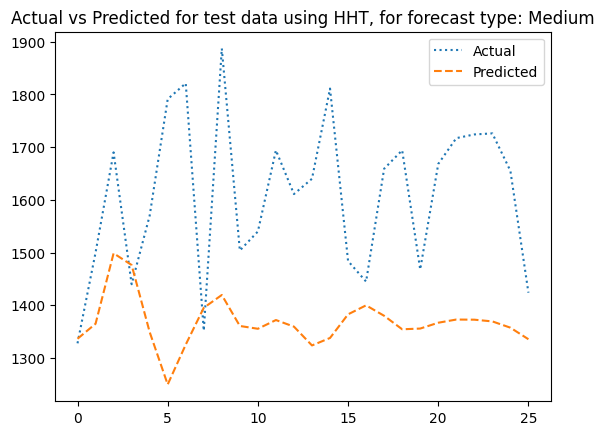

In [20]:
# calculating RMSE loss and  comparing the results
y_test_pred = np.array(y_test_pred_final)
y_test_true = np.array(cases_time_series[-test_size:])
# print("The RMSE loss is: ", np.sqrt(np.mean((y_test_pred - y_test_true)**2)))

rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
mae = np.mean(np.abs(y_test_pred - y_test_true))
mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

# tabulate the results
results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
print("The results are:")
print(results)



plt.plot(y_test_true, label="Actual", linestyle= "dotted")
plt.plot(y_test_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted for test data using HHT, for forecast type: "+forecast_type)
plt.legend()
plt.show()